## Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import datetime
import vectorbt as vbt
import requests
import apimoex
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

## Начальные условия

In [2]:
money = 100000
start = datetime.datetime(2018, 1, 1)
finish = datetime.datetime(2018, 12, 31)
stop_loss_pr = 0.05
fast_window = 30 #торговые свечи
slow_window = 90 #торговые свечи
#в окнах считаем простое скользящее среднее
interval = 60


## Загрузка данных

In [3]:
#загрузила данные 
with requests.Session() as session:
    data = apimoex.get_market_candles(session, 'YNDX', interval=interval, start= start, end=finish)
    df = pd.DataFrame(data)
    df.set_index(pd.to_datetime(df['begin']), inplace=True)
    df.drop(['begin'], axis=1, inplace=True)
df=df[['open','high','low','close']] 
df

,open,high,low,close
begin,,,,
2018-01-03 09:00:00,1919.0,1919.0,1919.0,1919.0
2018-01-03 10:00:00,1920.0,1927.0,1915.0,1926.5
2018-01-03 11:00:00,1925.0,1926.0,1920.0,1921.0
2018-01-03 12:00:00,1920.0,1927.0,1920.0,1924.0
2018-01-03 13:00:00,1923.0,1924.5,1918.5,1924.5
...,...,...,...,...
2018-12-29 14:00:00,1928.0,1929.5,1926.0,1928.5
2018-12-29 15:00:00,1928.5,1930.0,1920.0,1928.5
2018-12-29 16:00:00,1926.5,1928.5,1922.0,1925.0


In [4]:
df= df.rename(columns={'open':'Open', 'high': 'High','low': 'Low','close': 'Close'})
df.columns

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

## Часть на удовлетворительно

In [5]:
# сделала скользящие
fast_ma = vbt.MA.run(df['Open'], fast_window,short_name='fast')
slow_ma = vbt.MA.run(df['Open'], slow_window,short_name='slow')
sig_buy = fast_ma.ma_crossed_above(slow_ma) #  когда покупают
sig_sale = fast_ma.ma_crossed_below(slow_ma) #когда продают

#fast_ma.plot()
fast_ma=fast_ma.ma.dropna()  # удалила наны, так как смысла их держать нет
slow_ma= slow_ma.ma.dropna() # удалила наны, так как смысла их держать нет

### Стоп лосс

In [6]:
sig_buy_p= df[sig_buy==True] # вывела все сигналы на покупку
sig_buy_p

df1=df.copy()
sig_b=sig_buy_p.copy()
sig_b['buy']=df1['Close']
df=df.merge(sig_b,on=['begin','Open','High','Low','Close'],how='left') 
df

,Open,High,Low,Close,buy
begin,,,,,
2018-01-03 09:00:00,1919.0,1919.0,1919.0,1919.0,NaN
2018-01-03 10:00:00,1920.0,1927.0,1915.0,1926.5,NaN
2018-01-03 11:00:00,1925.0,1926.0,1920.0,1921.0,NaN
2018-01-03 12:00:00,1920.0,1927.0,1920.0,1924.0,NaN
2018-01-03 13:00:00,1923.0,1924.5,1918.5,1924.5,NaN
...,...,...,...,...,...
2018-12-29 14:00:00,1928.0,1929.5,1926.0,1928.5,NaN
2018-12-29 15:00:00,1928.5,1930.0,1920.0,1928.5,NaN
2018-12-29 16:00:00,1926.5,1928.5,1922.0,1925.0,NaN


In [7]:
df3=df.copy()
df3['buy']=df3['buy'].fillna(method='ffill')

df3=df3.dropna(subset='buy')

df2=df3.copy()
df2

C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\2509640027.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Open,High,Low,Close,buy
begin,,,,,
2018-02-14 17:00:00,2159.0,2208.5,2146.0,2201.5,2201.5
2018-02-14 18:00:00,2198.0,2220.5,2195.5,2200.0,2201.5
2018-02-15 09:00:00,2250.0,2250.0,2250.0,2250.0,2201.5
2018-02-15 10:00:00,2230.5,2257.0,2211.0,2239.0,2201.5
2018-02-15 11:00:00,2239.0,2253.0,2222.0,2250.0,2201.5
...,...,...,...,...,...
2018-12-29 14:00:00,1928.0,1929.5,1926.0,1928.5,1910.0
2018-12-29 15:00:00,1928.5,1930.0,1920.0,1928.5,1910.0
2018-12-29 16:00:00,1926.5,1928.5,1922.0,1925.0,1910.0


In [8]:
df2['stop']=df2['buy']*(1-stop_loss_pr)
df2['sig_stop']= np.where(df2['stop']<df2['Low'],False,True) 
stop_sig =df2[df2['sig_stop']==True].drop_duplicates(subset=['sig_stop','stop'])
stop_sig # вывела все стоп сигналы в целом, при этом они не проверены (неизвестно после или до закрытия выявлены)


,Open,High,Low,Close,buy,stop,sig_stop
begin,,,,,,,
2018-03-26 17:00:00,2381.5,2385.0,2335.0,2335.5,2465.0,2341.750,True
2018-04-25 17:00:00,2021.0,2063.0,1982.0,2019.5,2124.0,2017.800,True
2018-05-29 16:00:00,2096.0,2097.0,2059.0,2075.0,2177.0,2068.150,True
2018-06-26 16:00:00,2170.5,2195.0,2150.5,2186.0,2276.5,2162.675,True
2018-07-30 10:00:00,2348.5,2364.5,2325.5,2355.0,2458.0,2335.100,True
2018-10-18 18:00:00,2308.0,2356.5,2185.0,2235.0,2308.0,2192.600,True
2018-11-20 17:00:00,1869.0,1888.5,1851.0,1884.5,1954.5,1856.775,True
2018-12-06 17:00:00,1914.0,1917.0,1868.5,1890.5,1971.0,1872.450,True


In [9]:
sig_sale_p= df1[sig_sale==True] # вывела сигнал на продажу (сигнал идет по опен, но мы продаем по клоус, так что я брала клоус)
sig_s=sig_sale_p.copy()
sig_s['sale']=df1['Close']
sig_s

,Open,High,Low,Close,sale
begin,,,,,
2018-02-06 13:00:00,2083.0,2083.0,2050.0,2058.5,2058.5
2018-02-28 17:00:00,2366.0,2371.0,2327.0,2341.5,2341.5
2018-03-20 14:00:00,2441.5,2445.0,2437.0,2437.5,2437.5
2018-03-26 09:00:00,2377.0,2377.0,2377.0,2377.0,2377.0
2018-04-26 11:00:00,2062.0,2062.5,2041.0,2044.5,2044.5
2018-05-17 09:00:00,2123.0,2123.0,2123.0,2123.0,2123.0
2018-06-11 17:00:00,2197.0,2200.0,2179.0,2196.0,2196.0
2018-06-25 13:00:00,2221.5,2224.5,2215.5,2220.0,2220.0
2018-07-24 13:00:00,2357.0,2361.0,2354.0,2359.5,2359.5


In [10]:
sov = pd.concat([sig_s,stop_sig,sig_b]).sort_values(by='begin')
sov['buy']= sov['buy'].fillna(method='ffill')
sov=sov.dropna(subset='buy')
sov['sig_stop']= sov['sig_stop'].replace(np.nan,False)
sov
#тут sale - цена по которой она продалась и ей и соотвестует индекс, а buy - цена, по которой покупалась изначально просто 

C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\1099777830.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\1099777830.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Open,High,Low,Close,sale,buy,stop,sig_stop
begin,,,,,,,,
2018-02-14 17:00:00,2159.0,2208.5,2146.0,2201.5,NaN,2201.5,NaN,False
2018-02-28 17:00:00,2366.0,2371.0,2327.0,2341.5,2341.5,2201.5,NaN,False
2018-03-09 09:00:00,2474.0,2474.0,2474.0,2474.0,NaN,2474.0,NaN,False
2018-03-20 14:00:00,2441.5,2445.0,2437.0,2437.5,2437.5,2474.0,NaN,False
2018-03-22 10:00:00,2481.0,2481.5,2453.5,2465.0,NaN,2465.0,NaN,False
2018-03-26 09:00:00,2377.0,2377.0,2377.0,2377.0,2377.0,2465.0,NaN,False
2018-03-26 17:00:00,2381.5,2385.0,2335.0,2335.5,NaN,2465.0,2341.750,True
2018-04-25 14:00:00,2127.5,2129.5,2106.0,2124.0,NaN,2124.0,NaN,False
2018-04-25 17:00:00,2021.0,2063.0,1982.0,2019.5,NaN,2124.0,2017.800,True


In [11]:
sov=sov.dropna(subset=['sale','stop'],how='all')
sov1=sov.copy()
sov1['sale_f']=sov1['sale'].fillna(method='ffill') # либо стоп лосс был до закрытия, либо после. так что беру два столбца, а потом дропаю дубликаты
sov1['sale_b']=sov1['sale'].fillna(method='bfill')
sov1=sov1.drop_duplicates(subset=['buy','sale_f'],keep='first')
sov1=sov1.drop_duplicates(subset=['buy','sale_b'],keep='first')

sov1

C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\1206369633.py:3: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\1206369633.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Open,High,Low,Close,sale,buy,stop,sig_stop,sale_f,sale_b
begin,,,,,,,,,,
2018-02-28 17:00:00,2366.0,2371.0,2327.0,2341.5,2341.5,2201.5,NaN,False,2341.5,2341.5
2018-03-20 14:00:00,2441.5,2445.0,2437.0,2437.5,2437.5,2474.0,NaN,False,2437.5,2437.5
2018-03-26 09:00:00,2377.0,2377.0,2377.0,2377.0,2377.0,2465.0,NaN,False,2377.0,2377.0
2018-04-25 17:00:00,2021.0,2063.0,1982.0,2019.5,NaN,2124.0,2017.80,True,2377.0,2044.5
2018-05-17 09:00:00,2123.0,2123.0,2123.0,2123.0,2123.0,2177.0,NaN,False,2123.0,2123.0
2018-06-11 17:00:00,2197.0,2200.0,2179.0,2196.0,2196.0,2143.0,NaN,False,2196.0,2196.0
2018-06-25 13:00:00,2221.5,2224.5,2215.5,2220.0,2220.0,2276.5,NaN,False,2220.0,2220.0
2018-07-24 13:00:00,2357.0,2361.0,2354.0,2359.5,2359.5,2284.0,NaN,False,2359.5,2359.5
2018-07-30 10:00:00,2348.5,2364.5,2325.5,2355.0,NaN,2458.0,2335.10,True,2359.5,2282.0


### Так как у нас теперь введен стоп лосс, стоит заново выделить сигналы на продажу(с учетом стоп лосов) и отдельно стоп лоссы

In [12]:

df4=df3.merge(sov1[sov1['sig_stop']==False],how='left',on=['begin','High','Low','Close','Open','buy']) 

df4['sig_stop']=df4['sig_stop'].replace(False,True)
df4=df4.replace(np.nan,False)
sig_sale=df4['sig_stop']
sig_sale# закрытия (с учетом стоп лосов, но без них, они отдельно)
df4

C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\305186037.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Open,High,Low,Close,buy,sale,stop,sig_stop,sale_f,sale_b
begin,,,,,,,,,,
2018-02-14 17:00:00,2159.0,2208.5,2146.0,2201.5,2201.5,False,False,False,False,False
2018-02-14 18:00:00,2198.0,2220.5,2195.5,2200.0,2201.5,False,False,False,False,False
2018-02-15 09:00:00,2250.0,2250.0,2250.0,2250.0,2201.5,False,False,False,False,False
2018-02-15 10:00:00,2230.5,2257.0,2211.0,2239.0,2201.5,False,False,False,False,False
2018-02-15 11:00:00,2239.0,2253.0,2222.0,2250.0,2201.5,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2018-12-29 14:00:00,1928.0,1929.5,1926.0,1928.5,1910.0,False,False,False,False,False
2018-12-29 15:00:00,1928.5,1930.0,1920.0,1928.5,1910.0,False,False,False,False,False
2018-12-29 16:00:00,1926.5,1928.5,1922.0,1925.0,1910.0,False,False,False,False,False


In [13]:
stop_losses= sov1[sov1['sig_stop']==True]['sig_stop']
df5=df3.merge(sov1[sov1['sig_stop']==True],how='left',on=['begin','High','Low','Close','Open','buy'])
df5=df5.replace(np.nan,False)
stop_loss=df5['sig_stop']
stop_loss  # стоп лосы

C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\135138633.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



begin
2018-02-14 17:00:00    False
2018-02-14 18:00:00    False
2018-02-15 09:00:00    False
2018-02-15 10:00:00    False
2018-02-15 11:00:00    False
                       ...  
2018-12-29 14:00:00    False
2018-12-29 15:00:00    False
2018-12-29 16:00:00    False
2018-12-29 17:00:00    False
2018-12-29 18:00:00    False
Name: sig_stop, Length: 2232, dtype: bool

In [14]:
sig_buy # просто вывела для удобства

begin
2018-01-03 09:00:00    False
2018-01-03 10:00:00    False
2018-01-03 11:00:00    False
2018-01-03 12:00:00    False
2018-01-03 13:00:00    False
                       ...  
2018-12-29 14:00:00    False
2018-12-29 15:00:00    False
2018-12-29 16:00:00    False
2018-12-29 17:00:00    False
2018-12-29 18:00:00    False
Length: 2526, dtype: bool

## Визуализирование

In [15]:
#визуаоизашка свечей по часам

trace = go.Candlestick(
                x=df.index, 
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])


data = [trace]
fig = go.Figure(data=data)  
#сверху свечи, снизу ohlc
#fig= df.vbt.ohlcv.plot() 

fig = fast_ma.vbt.plot(trace_kwargs=dict(name='Fast MA',marker=dict(color='pink')), fig=fig)
fig = slow_ma.vbt.plot(trace_kwargs=dict(name='Slow MA',marker=dict(color='orange')), fig=fig)
fig = sig_buy.vbt.signals.plot_as_entry_markers(df['Close'], fig=fig,trace_kwargs=dict(name='Buy')) #мб поменять на сиг бай и сиг сейл
fig = sig_sale.vbt.signals.plot_as_exit_markers(df4['Close'], fig=fig, trace_kwargs=dict(name='Sale')) 
fig= stop_loss.vbt.signals.plot_as_markers(df5['stop'],fig=fig, trace_kwargs=dict(name='stop-loss', marker=dict(symbol='triangle-down',color='black'))) #

# надо  еще внизу окно сделать с 0 и 1 (4 пункт)
fig


C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\2670036994.py:7: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\2670036994.py:15: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



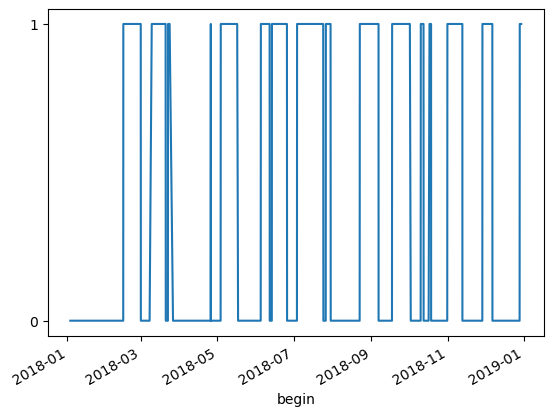

In [16]:
sov1['sig_stop']=True # все вообще стопы равны тру
sov1=sov1.replace(np.nan,False)
sov1['price']=np.where(sov1['stop']==False,sov1['sale'],sov1['stop'])
df['sig_buy']= sig_buy
df['sig_stop']=sov1['sig_stop']
df['price'] = sov1['price']
df=df.replace(np.nan,False)
df['price']=np.where(df['sig_stop']==True,df['price'],df['Close'])
sig_stop=df['sig_stop']
#df['price']=df['Close']
df['price']=df['price'].astype(float)
#cверху часть дл отчета, снизу продолжение визуализации

df['pos']=df['sig_buy'] + df['sig_stop']
df['pos']=df['pos'].replace([False,True],[0,1]).cumsum()
df['pos']= np.where(df['pos']%2==0,0,1)
df['pos'].plot()
plt.yticks([0,1])
plt.show()

### Отчет по прибыли

In [17]:
pf = vbt.Portfolio.from_signals(df['price'], sig_buy, sig_stop,init_cash=money,freq='1h')
pf.total_profit()

-23776.781668931057

### Oтчет по сделкам

In [18]:
#(я так понимаю имеется в виду колчиество сделок и мб разница между ценой продажи и ценой покупки)
# Количество сделок = количеству стопов
col= df['sig_stop'].sum() # количество сделок
col

15

In [19]:
df['buy']=df['buy'].replace(False,np.nan)
df['buy']=df['buy'].fillna(method='ffill')
sdelki=df[df['sig_stop']==True]
sdelki['report'] = sdelki['price']-sdelki['buy']
sdelki

C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\1255026194.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\1255026194.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\Larisa\AppData\Local\Temp\ipykernel_10988\1255026194.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,buy,sig_buy,sig_stop,price,pos,report
begin,,,,,,,,,,
2018-02-28 17:00:00,2366.0,2371.0,2327.0,2341.5,2201.5,False,True,2341.50,0,140.00
2018-03-20 14:00:00,2441.5,2445.0,2437.0,2437.5,2474.0,False,True,2437.50,0,-36.50
2018-03-26 09:00:00,2377.0,2377.0,2377.0,2377.0,2465.0,False,True,2377.00,0,-88.00
2018-04-25 17:00:00,2021.0,2063.0,1982.0,2019.5,2124.0,False,True,2017.80,0,-106.20
2018-05-17 09:00:00,2123.0,2123.0,2123.0,2123.0,2177.0,False,True,2123.00,0,-54.00
2018-06-11 17:00:00,2197.0,2200.0,2179.0,2196.0,2143.0,False,True,2196.00,0,53.00
2018-06-25 13:00:00,2221.5,2224.5,2215.5,2220.0,2276.5,False,True,2220.00,0,-56.50
2018-07-24 13:00:00,2357.0,2361.0,2354.0,2359.5,2284.0,False,True,2359.50,0,75.50
2018-07-30 10:00:00,2348.5,2364.5,2325.5,2355.0,2458.0,False,True,2335.10,0,-122.90


##### PS

In [20]:
#PS пробовала так, но как-то по процентам стоплосс не сходится (на рисунке на спаде сильном видно) (цена продажи в результате сильно ниже, чем та, которая должна быть по условию задания). Мой стоплосс (сделанный вручную),как мне кажется, больше соответствует данному заданию.Поэтому остановилась на решении выше. Думаю, что рассхождения именно из-за того, что тут по-другому как-то понимается стоп лосс, но я не знаю
with requests.Session() as session:
    data = apimoex.get_market_candles(session, 'YNDX', interval=interval, start= start, end=finish)
    df = pd.DataFrame(data)
    df.set_index(pd.to_datetime(df['begin']), inplace=True)
    df.drop(['begin'], axis=1, inplace=True)
df=df[['open','high','low','close']] 
df
# сделала скользящие
fast_ma = vbt.MA.run(df['open'], fast_window,short_name='fast')
slow_ma = vbt.MA.run(df['open'], slow_window,short_name='slow')
sig_buy = fast_ma.ma_crossed_above(slow_ma) #  когда покупают
sig_sale = fast_ma.ma_crossed_below(slow_ma) #когда продают

#fast_ma.plot()
fast_ma=fast_ma.ma.dropna()  # удалила наны, так как смысла их держать нет
slow_ma= slow_ma.ma.dropna() # удалила наны, так как смысла их держать нет
pf = vbt.Portfolio.from_signals(df['close'], sig_buy, sig_sale,init_cash=money,freq='1h',sl_stop=0.05)
pf.plot()


FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '7b5e3a88-ddd5-4123-8f98-d88c72c5a043',
              'x': array([datetime.datetime(2018, 1, 3, 9, 0),
                          datetime.datetime(2018, 1, 3, 10, 0),
                          datetime.datetime(2018, 1, 3, 11, 0), ...,
                          datetime.datetime(2018, 12, 29, 16, 0),
                          datetime.datetime(2018, 12, 29, 17, 0),
                          datetime.datetime(2018, 12, 29, 18, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([1919. , 1926.5, 1921. , ..., 1925. , 1926.5, 1930. ]),
              'yaxis': 'y'},
             {'customdata': array([[ 0.        , 45.42357484,  0.        ],
                                   [ 2.        , 42.99082477,  0.        ],
                                   [ 4.        ,